In [1]:
import sys
#sys.path.append('/Users/mgehan/Documents/github/plantcv/')
#sys.path.append('/home/user/plantcv/')

In [2]:
# STEP 1: Import package code
%matplotlib inline
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
import plantcv as pcv
from plantcv.dev.color_palette import color_palette

/Users/mgehan/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
# STEP 2: Set global variables
device = 0                                                               # Workflow step counter
debug = 'plot'                                                           # Plot debug images to the notebook
rgb_img = './examples/shoot-images/VIS_SV_0_z2500_h2_g0_e82_180256.png'  # Image filename

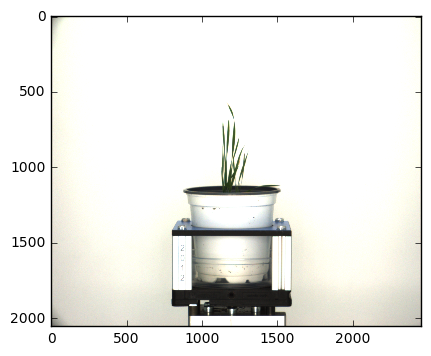

In [4]:
# STEP 3: Read RGB image and plot it to the notebook
# Inputs:
#    filename = name of image file
img, path, filename = pcv.readimage(rgb_img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

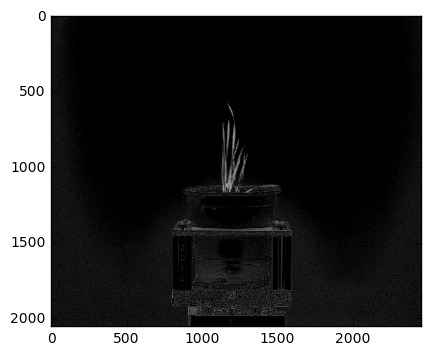

In [5]:
# STEP 4: Convert image from RGB colorspace to HSV colorspace
# Keep only the Saturation channel (grayscale)
# Inputs:
#    img     = image object, RGB colorspace
#    channel = color subchannel (h = hue, s = saturation, v = value/intensity/brightness)
#    device  = device number. Used to count steps in the workflow
#    debug   = None, print, or plot. Print = save to file, Plot = print to screen.
device, img_gray_sat = pcv.rgb2gray_hsv(img, 's', device, debug)

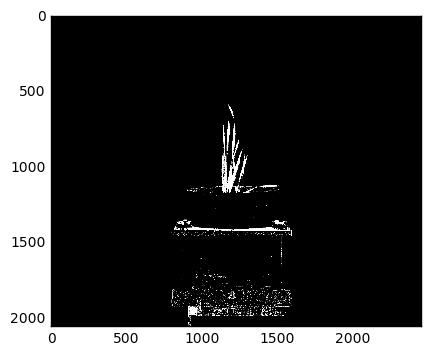

In [6]:
# STEP 5: Set a binary threshold on the Saturation channel image
# Inputs:
#    img         = img object, grayscale
#    threshold   = threshold value (0-255)
#    maxValue    = value to apply above threshold (usually 255 = white)
#    object_type = light or dark
#                  - If object is light then standard thresholding is done
#                  - If object is dark then inverse thresholding is done
#    device      = device number. Used to count steps in the pipeline
#    debug       = None, print, or plot. Print = save to file, Plot = print to screen.
device, img_binary = pcv.binary_threshold(img_gray_sat, 50, 255, 'light', device, debug)
#                                                       ^
#                                                       |
#                                                       adjust this value

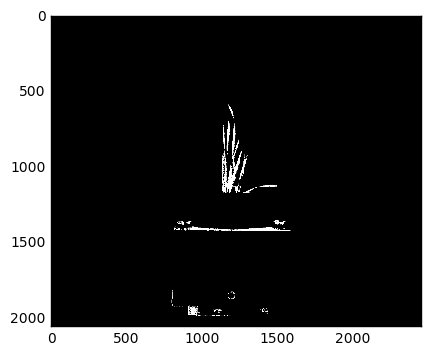

In [7]:
# STEP 6: Fill in small objects (speckles)
# Inputs:
#    img    = image object, grayscale. img will be returned after filling
#    mask   = image object, grayscale. This image will be used to identify contours
#    size   = minimum object area size in pixels (integer)
#    device = device number. Used to count steps in the pipeline
#    debug  = None, print, or plot. Print = save to file, Plot = print to screen.
mask = np.copy(img_binary)
device, fill_image = pcv.fill(img_binary, mask, 300, device, debug)
#                                               ^
#                                               |
#                                               adjust this value

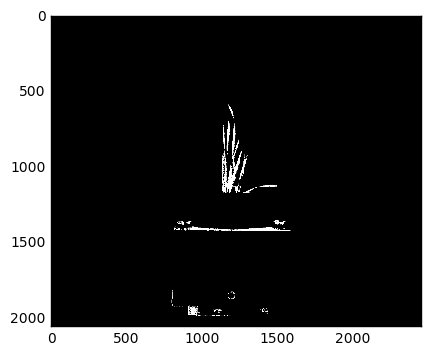

In [8]:
# STEP 7: Dilate so that you don't lose leaves (just in case)
# Inputs:
#    img     = input image
#    kernel  = integer
#    i       = interations, i.e. number of consecutive filtering passes
#    device  = device number. Used to count steps in the pipeline
#    debug   = None, print, or plot. Print = save to file, Plot = print to screen.

device, dilated = pcv.dilate(fill_image, 1, 1, device, debug)

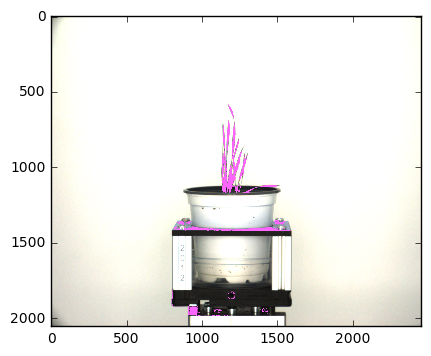

In [9]:
# STEP 8: Find objects (contours: black-white boundaries)
# Inputs:
#    img       = image that the objects will be overlayed
#    mask      = what is used for object detection
#    device    = device number.  Used to count steps in the pipeline
#    debug     = None, print, or plot. Print = save to file, Plot = print to screen.
device, id_objects, obj_hierarchy = pcv.find_objects(img, dilated, device, debug)

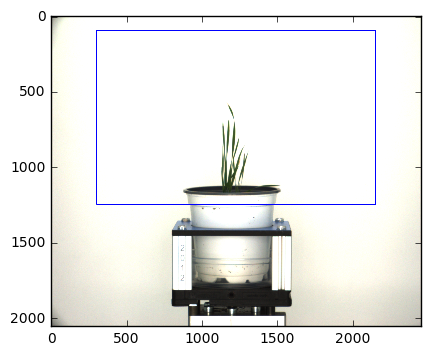

In [10]:
# STEP 9: Define region of interest (ROI)
# Inputs:
#    img       = img to overlay roi
#    roi       = default (None) or user input ROI image, object area should be white and background should be black,
#                has not been optimized for more than one ROI
#    roi_input = type of file roi_base is, either 'binary', 'rgb', or 'default' (no ROI inputted)
#    shape     = desired shape of final roi, either 'rectangle' or 'circle', if  user inputs rectangular roi but chooses
#                'circle' for shape then a circle is fitted around rectangular roi (and vice versa)
#    device    = device number.  Used to count steps in the pipeline
#    debug     = None, print, or plot. Print = save to file, Plot = print to screen.
#    adjust    = either 'True' or 'False', if 'True' allows user to adjust ROI
#    x_adj     = adjust center along x axis
#    y_adj     = adjust center along y axis
#    w_adj     = adjust width
#    h_adj     = adjust height
device, roi, roi_hierarchy = pcv.define_roi(img, 'rectangle', device, None, 'default', debug, True, 
                                             300, 100, -300, -800)
#                                            ^                ^
#                                            |________________|
#                                            adjust these four values

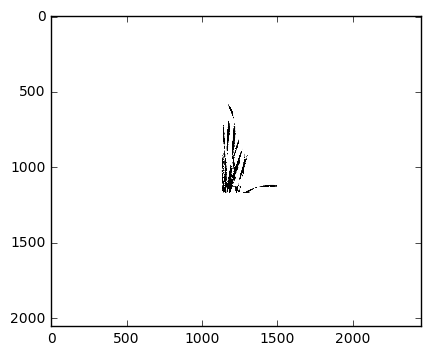

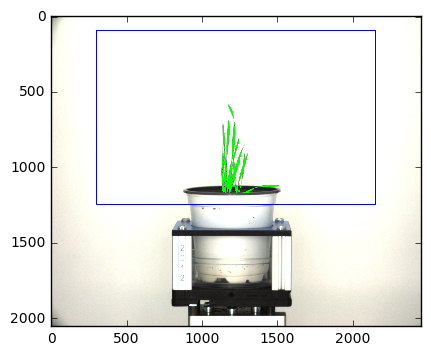

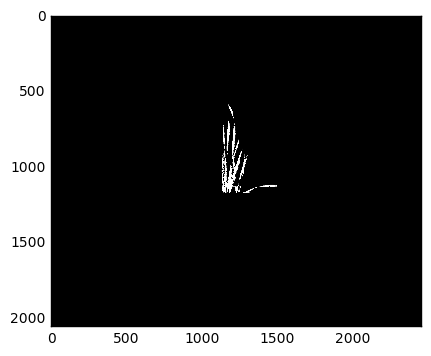

In [11]:
# STEP 10: Keep objects that overlap with the ROI
# Inputs:
#    img            = img to display kept objects
#    roi_type       = 'cutto' or 'partial' (for partially inside)
#    roi_contour    = contour of roi, output from "View and Ajust ROI" function
#    roi_hierarchy  = contour of roi, output from "View and Ajust ROI" function
#    object_contour = contours of objects, output from "Identifying Objects" fuction
#    obj_hierarchy  = hierarchy of objects, output from "Identifying Objects" fuction
#    device         = device number.  Used to count steps in the pipeline
#    debug          = None, print, or plot. Print = save to file, Plot = print to screen.
device, roi_objects, roi_obj_hierarchy, kept_mask, obj_area = pcv.roi_objects(img, 'partial', roi, roi_hierarchy,
                                                                           id_objects, obj_hierarchy, device,
                                                                           debug)

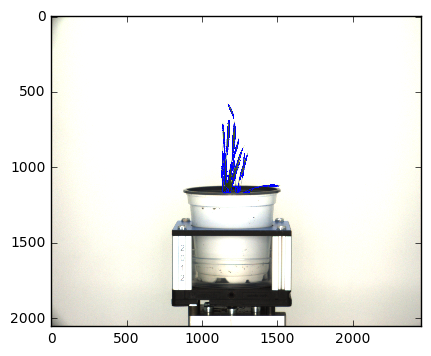

In [12]:
# STEP 11: Object combine kept objects
# Inputs:
#    contours = object list
#    device   = device number. Used to count steps in the pipeline
#    debug    = None, print, or plot. Print = save to file, Plot = print to screen.
device, obj, mask = pcv.object_composition(img, roi_objects, roi_obj_hierarchy, 
                                           device, debug)

In [13]:
# STEP 12: If you want to save output images set an outfile
outfile='./examples/shoot-images/output/'+str(filename[:-4])+'-outfile'
print(outfile)

./examples/shoot-images/output/VIS_SV_0_z2500_h2_g0_e82_180256-outfile


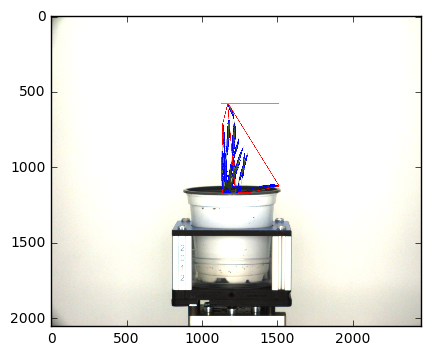

In [14]:
#STEP 13: Measure the area and other shape properties of the plant
# Inputs:
#    img             = image object (most likely the original), color(RGB)
#    imgname         = name of image
#    obj             = single or grouped contour object
#    device          = device number. Used to count steps in the pipeline
#    debug           = None, print, or plot. Print = save to file, Plot = print to screen.
#    filename        = False or image name. If defined print image
device, shape_header, shape_data, shape_img = pcv.analyze_object(img, rgb_img, obj, mask, device, debug,outfile)

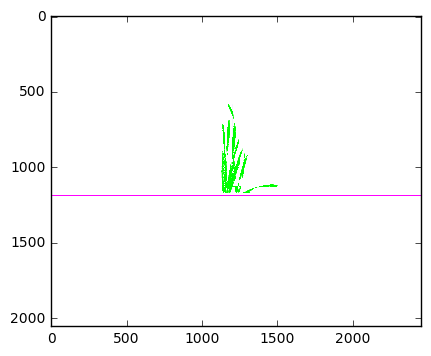

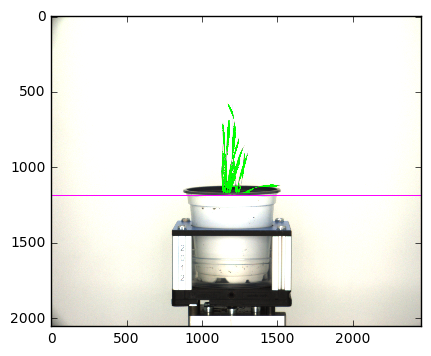

In [15]:
#STEP 14: Add a boundary line
#Inputs:
#    img             = image
#    imgname         = name of input image
#    obj             = single or grouped contour object
#    mask            = mask made from selected contours
#    shape_header    = pass shape header data to function
#    shape_data      = pass shape data so that analyze_bound data can be appended to it
#    line_position   = position of boundry line (a value of 0 would draw the line through the bottom of the image)
#    device          = device number. Used to count steps in the pipeline
#    debug           = None, print, or plot. Print = save to file, Plot = print to screen.
#    filename        = False or image name. If defined print image.

device, boundary_header,boundary_data, boundary_img1= pcv.analyze_bound(img,img,obj, mask, 860, device,debug,outfile)

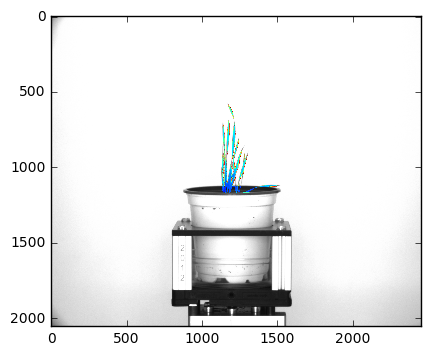

In [16]:
#STEP 15: Analyze color
#Inputs:
#    histogram       = a normalized histogram of color values from one color channel
#    bins            = number of color bins the channel is divided into
#    img             = input image
#    mask            = binary mask image
#    background      = what background image?: channel image (img) or white
#    channel         = color channel name
#    filename        = input image filename
#    resolution      = output image resolution
#    analysis_images = list of analysis image filenames
#    debug           = print or plot. Print = save to file, Plot = print to screen.

device, color_header,color_data,color_img= pcv.analyze_color(img,img, mask, 256, device, debug,None,'v','img',300,outfile)

In [17]:
#STEP 16: Write data headers and data out to a file

outputfile= './examples/shoot-images/output/'+ str(filename[:-4]+'-results.txt')
result=open(outputfile,"a")
result.write('\t'.join(map(str,shape_header)))
result.write("\n")
result.write('\t'.join(map(str,shape_data)))
result.write("\n")
for row in shape_img:
    result.write('\t'.join(map(str,row)))
    result.write("\n")
result.write('\t'.join(map(str,color_header)))
result.write("\n")
result.write('\t'.join(map(str,color_data)))
result.write("\n")
result.write('\t'.join(map(str,boundary_header)))
result.write("\n")
result.write('\t'.join(map(str,boundary_data)))
result.write("\n")
result.write('\t'.join(map(str,boundary_img1)))
result.write("\n")
for row in color_img:
    result.write('\t'.join(map(str,row)))
    result.write("\n")
result.close()


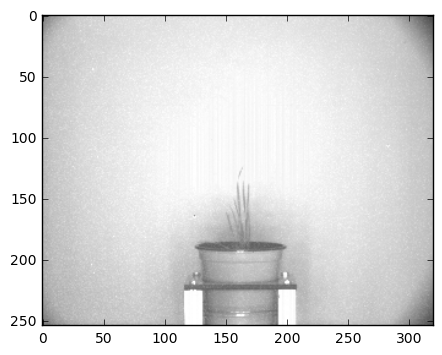

In [18]:
# STEP 17: Find a corresponding NIR image from the same snapshot as the VIS image.
#Inputs:
#   path     = path to vis image
#   filename = vis image file name
#   device   = pipeline step counter
#   debug    = None, print, or plot. Print = save to file, Plot = print to screen.
device, nirpath=pcv.get_nir(path,filename,device,debug)

# read in image as a 3 channel image to do processing on
nir, path1, filename1=pcv.readimage(nirpath)

# read in  image as a single channel image (native)
nir2=cv2.imread(nirpath,0)

# print the image just to see it
plt.imshow(cv2.cvtColor(nir, cv2.COLOR_BGR2RGB))
plt.show()

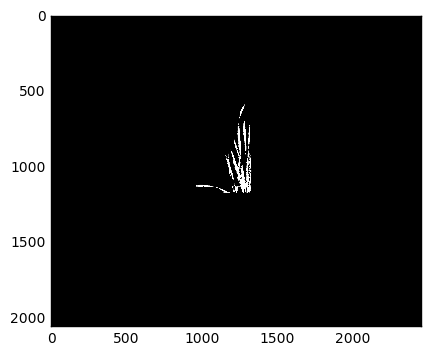

In [19]:
#STEP 18: Notice that the NIR image is fliped from the VIS image
#Inputs:
#    img       = image to be flipped
#    direction = "horizontal" or "vertical"
#    device    = device counter
#    debug     = None, print, or plot. Print = save to file, Plot = print to screen.

device, f_mask= pcv.flip(mask,"vertical",device,debug)

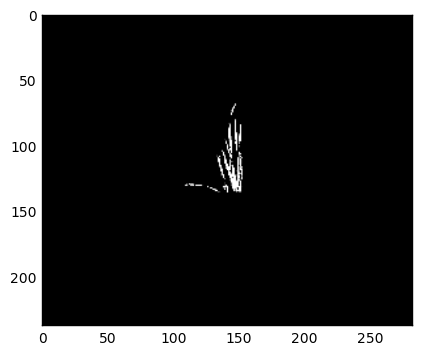

In [20]:
# STEP 19: Resize mask so that it can be used over NIR image.
#Inputs:
#    img      = image to resize
#    resize_x = scaling factor
#    resize_y = scaling factor
#    device   = device counter
#    debug    = None, print, or plot. Print = save to file, Plot = print to screen.

device, nmask = pcv.resize(f_mask, 0.11532,0.11532, device, debug)

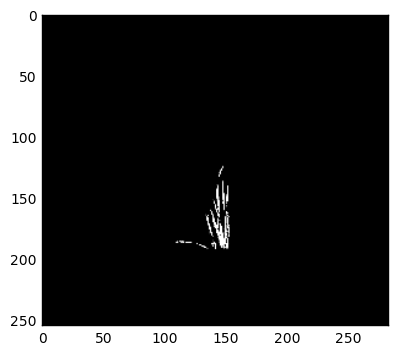

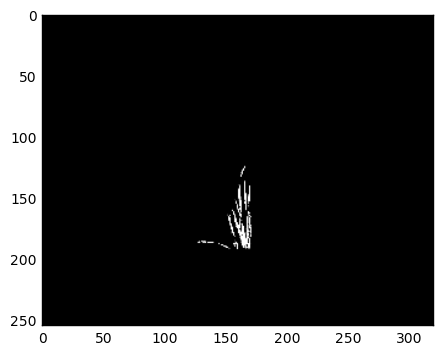

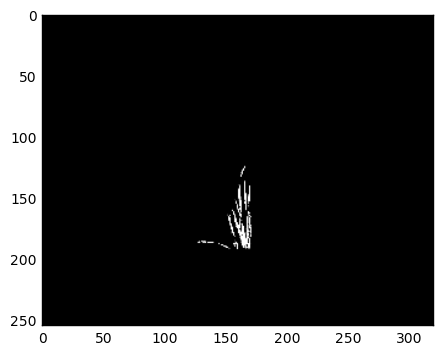

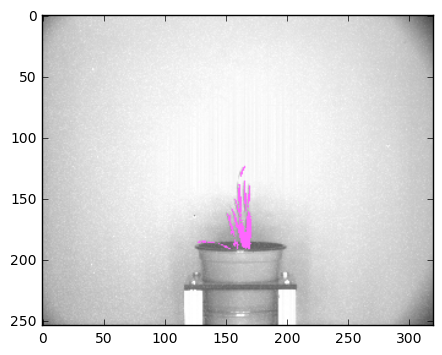

In [21]:
#STEP 20: Takes a mask and positions it over another image, it also resizes the resulting
# image mask so that both images are the same size.

#Inputs:
#    img     = image to mask
#    mask    = mask to use (must be correct size, if, not use make_resize_mask function)
#    x       = x position
#    y       = y position
#    v_pos   = push from "top" or "bottom"
#    h_pos   = push to "right" or "left"
#    device  = device counter
#    debug   = None, print, or plot. Print = save to file, Plot = print to screen.

device,newmask=pcv.crop_position_mask(nir,nmask,device,57,2,"top","right",debug)

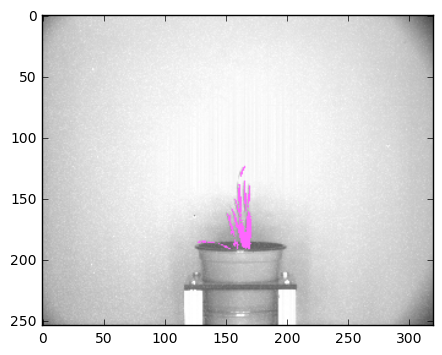

In [22]:
# STEP 21: Find objects (contours: black-white boundaries)
# Inputs:
#    img       = image that the objects will be overlayed
#    mask      = what is used for object detection
#    device    = device number.  Used to count steps in the pipeline
#    debug     = None, print, or plot. Print = save to file, Plot = print to screen.
 
device, nir_objects,nir_hierarchy = pcv.find_objects(nir, newmask, device, debug)

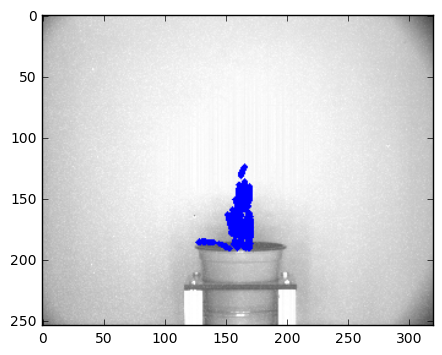

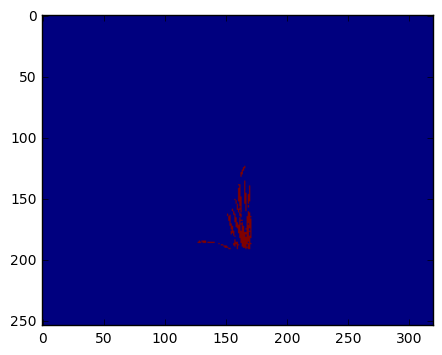

In [23]:
# STEP 22: Object combine kept objects
# Inputs:
#    contours = object list
#    device   = device number. Used to count steps in the pipeline
#    debug    = None, print, or plot. Print = save to file, Plot = print to screen.

device, nir_combined, nir_combinedmask = pcv.object_composition(nir, nir_objects, nir_hierarchy, device, debug)

plt.imshow(nir_combinedmask)
plt.show()

./examples/shoot-images/output/NIR_SV_0_z2500_h2_g0_e65_180265-nir-output


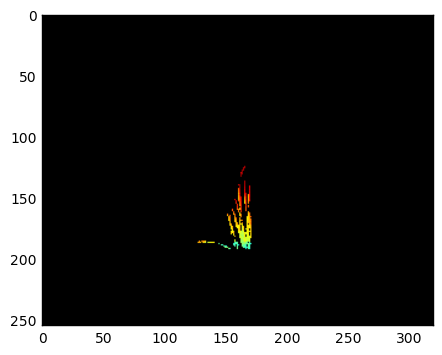

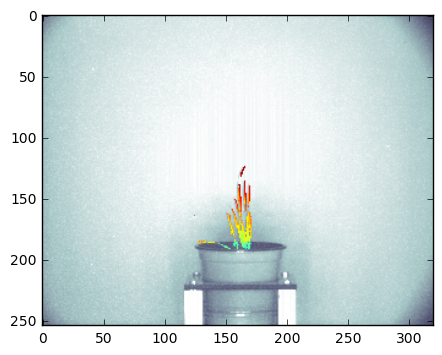

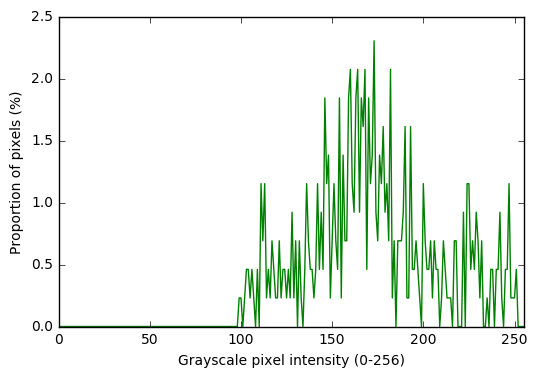

In [30]:
# STEP 23: If you want to save output NIR images set an outfile
outfile1='./examples/shoot-images/output/'+str(filename1[:-4])+"-nir-output"
print(outfile1)

device,nhist_header, nhist_data,nir_imgs= pcv.analyze_NIR_intensity(nir2, nir, nir_combinedmask, 256, device,True,debug, outfile1)

In [25]:
#STEP 16: Write data headers and data out to a file

outputfile1= './examples/shoot-images/output/'+ str(filename[:-4]+'-nir-results.txt')
coresult=open(outputfile1,"a")
coresult.write('\t'.join(map(str,nhist_header)))
coresult.write("\n")
coresult.write('\t'.join(map(str,nhist_data)))
coresult.write("\n")
for row in nir_imgs:
    coresult.write('\t'.join(map(str,row)))
    coresult.write("\n")

In [26]:
print(nhist_header)

['HEADER_HISTOGRAM', 'bin-number', 'bin-values', 'nir']


In [27]:
print(nhist_data)

['HISTOGRAM_DATA', 256, [1.0, 1.99609375, 2.9921875, 3.98828125, 4.984375, 5.98046875, 6.9765625, 7.97265625, 8.96875, 9.96484375, 10.9609375, 11.95703125, 12.953125, 13.94921875, 14.9453125, 15.94140625, 16.9375, 17.93359375, 18.9296875, 19.92578125, 20.921875, 21.91796875, 22.9140625, 23.91015625, 24.90625, 25.90234375, 26.8984375, 27.89453125, 28.890625, 29.88671875, 30.8828125, 31.87890625, 32.875, 33.87109375, 34.8671875, 35.86328125, 36.859375, 37.85546875, 38.8515625, 39.84765625, 40.84375, 41.83984375, 42.8359375, 43.83203125, 44.828125, 45.82421875, 46.8203125, 47.81640625, 48.8125, 49.80859375, 50.8046875, 51.80078125, 52.796875, 53.79296875, 54.7890625, 55.78515625, 56.78125, 57.77734375, 58.7734375, 59.76953125, 60.765625, 61.76171875, 62.7578125, 63.75390625, 64.75, 65.74609375, 66.7421875, 67.73828125, 68.734375, 69.73046875, 70.7265625, 71.72265625, 72.71875, 73.71484375, 74.7109375, 75.70703125, 76.703125, 77.69921875, 78.6953125, 79.69140625, 80.6875, 81.68359375, 82.6